# Curse Of Dimensionality

## References 

- https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote02_kNN.html
- https://www.youtube.com/@kilianweinberger698

In [57]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from scipy.spatial import minkowski_distance
from sklearn.datasets import make_classification, make_regression

np.random.seed(8888)
plt.style.use('fivethirtyeight')

## Concept

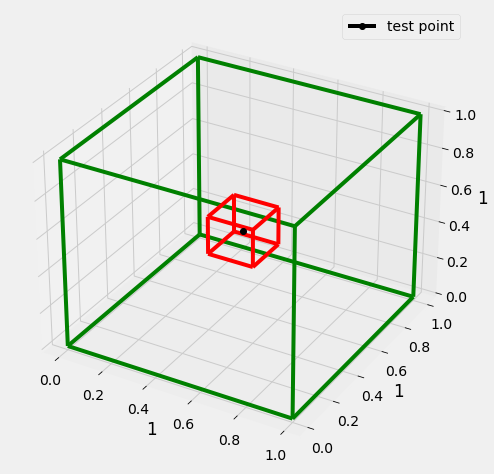

In [58]:
from itertools import product, combinations

fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(132, projection='3d')
r = [0, 1]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1] -  r[0]:
        ax.plot3D(*zip(s, e), color="green")

ax.set_xlabel('1')
ax.set_ylabel('1')
ax.set_zlabel('1')

l = [0.4, 0.6]

for s, e in combinations(np.array(list(product(l, l, l))), 2):
    if np.sum(np.abs(s-e)) == l[1] - l[0]:
        ax.plot3D(*zip(s, e), color="red")
        
        
ax.plot3D(0.5, 0.5, 0.5, marker='o', color='black', label='test point')

ax.legend()

plt.tight_layout()
plt.show()

* Lets consider we have a hypercube with edge of length 1 (green), data is uniformly distributed in this cube(plotted a 3D cube, as n dim cube would be difficult to plot.
* Now we have a test point(black), we have to identify a cube of possible l (red) that encapsulates k nearest neighbors of the test point.



* Volume of d dimensional cube of edge l is $l^d$ ($l^3$ for 3D cube) and this cube contains k data points($R^d$ real data points d dimensional) `uniformly distributed` out of n.

\begin{align}
\frac{l^d}{1^d} &\approx \frac{k}{n} \\
l &\approx \big(\frac{k}{n} \big)^{\frac{1}{d}}
\\
\text{let } & k=10, n=1000 \\
l &\approx \big( \frac{1}{100} \big)^{\frac{1}{d}}
\end{align}

In [59]:
x = []
k = 10
n = 1000
for d in [2, 10, 100, 1000, 10000]:
    x.append([d, (k/n)**(1/d)])
    
df = pd.DataFrame(x, columns=['d', 'l'])

df.head()

,d,l
0,2,0.100000
1,10,0.630957
2,100,0.954993
3,1000,0.995405
4,10000,0.999540


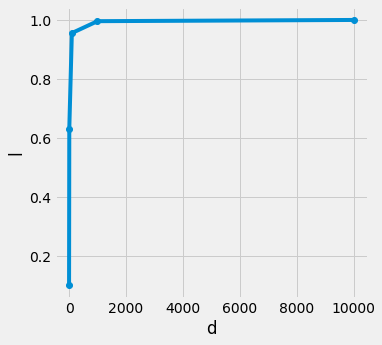

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot('d', 'l', 'o-', data=df)

ax.set_xlabel('d')
ax.set_ylabel('l')

plt.show()

* for uniformly distributed data point n in d dimensional hypercube, if want to want a l length cube that encapsulate k nearest neighbors, with increasing dimension d we are seeing that the length of l is reaching towards 1, means k nearest neighbors are iteratively overlapping the hypercube (essentially the same size)

```sql
                +-------------------+
                |+-----------------+|
                ||                 ||
                ||                 @|
                ||                 ||
                ||        x        ||
                ||                 |o
                ||                 ||
                ||                 ||
                ||                 ||
                |+-----------------+|
                +-------------------+
```

* Now here the concept we need to understand that the nearest neighbors are on the edges, why? because if they are not on the edges then the inner cube would've been smaller(because `nearest neighbors` possible of length l). That means the cube is empty in the middle. In high dimensional spaces everything is very far away from each other. interior is empty.
                                
* So, the difference between `x-@` and `x-o` distances is very less, as both the data points `@` and `o` are on the edges in high dimensions

## Proofs

### Classification

In [61]:
def generate_sparse_matrix(n_rows, n_cols, sparsity):

    # Number of zeros in the matrix
    num_zeros = int(n_rows * n_cols * sparsity)

    # Generate a flat array of ones and zeros
    flat_array = np.concatenate((np.ones(n_rows * n_cols - num_zeros), np.zeros(num_zeros)))

    # Shuffle the flat array randomly
    np.random.shuffle(flat_array)

    # Reshape the flat array into the desired matrix shape
    binary_matrix = np.reshape(flat_array, (n_rows, n_cols))
    
    return binary_matrix

Code below is one example how i am going to generate the data. 2 classses, 1 cluster per class, class separation around 5 and around 500 sample data points.
number of features will increase with increment in dimensions

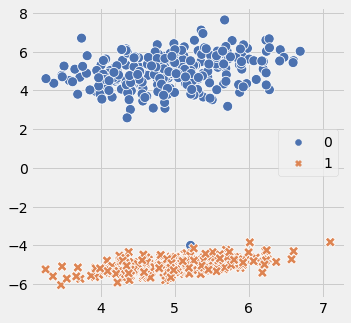

In [70]:
X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_classes=2, class_sep=5, scale=1.0,
                               n_clusters_per_class=1, random_state=666)

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax1, palette='deep', s=100)

plt.show()


* We are generating data for dimensions 2, 10, 100, 1000, 10000, 20000 features
* one data point extra for test (m + 1)
* we'll create sparse matrix(1%) to introduce sparsity in data as it is assumed that in higher dimensions sparsity increases in data points (vector space)
* Three types of euclidean distances are calculated :
    * class 0 and class 1 data points distances from test point
    * distances within class 0 data points and distances within class 1 data points
    * distances in class 0 and class 1 data points

In [72]:
n_samples = 501
n_features = [2, 10, 100, 1000, 10000, 20000]
distances = []
class0_test_distances = []
class1_test_distances = []
class0_within_distances = []
class1_within_distances = []
class0_class1_distances = []
sparse_points = []

for i in n_features:
    
    X, y = make_classification(n_samples=n_samples, n_features=i, n_redundant=0, n_classes=2, class_sep=5, scale=1.0,
                               n_clusters_per_class=1, random_state=666)
        
    sparse_matrix = generate_sparse_matrix(n_samples, i, 0.01)
    X = X * sparse_matrix
    
    test_point = X[-1]
    test_label = y[-1]
    X = X[:-1]
    y = y[:-1]
    
    sparse_points.append((n_samples * i) - sparse_matrix.sum())
    
    class1_idxs = np.where(y == 1)[0]
    class0_idxs = np.where(y == 0)[0]

    class0_test_distances.append(minkowski_distance(test_point, X[class0_idxs], p=2))
    class1_test_distances.append(minkowski_distance(test_point, X[class1_idxs], p=2))
    
    min_len = min(class0_idxs.shape[0], class1_idxs.shape[0])
    random_idxs_1 = np.random.randint(0, min_len, size=np.ceil(n_samples * 0.7).astype('int'))
    random_idxs_2 = np.random.randint(0, min_len, size=np.ceil(n_samples * 0.7).astype('int'))
    
    class0_within_distances.append(minkowski_distance(X[class0_idxs][random_idxs_1], X[class0_idxs][random_idxs_2], p=2))
    class1_within_distances.append(minkowski_distance(X[class1_idxs][random_idxs_1], X[class1_idxs][random_idxs_2], p=2))
    class0_class1_distances.append(minkowski_distance(X[class0_idxs][random_idxs_1], X[class1_idxs][random_idxs_2], p=2))

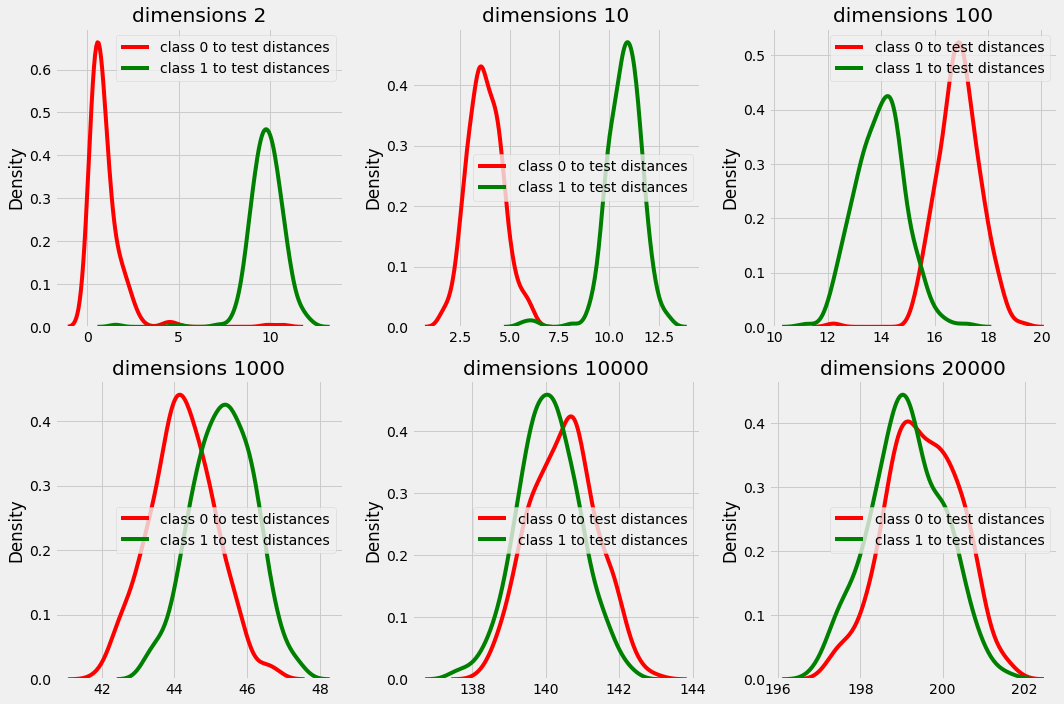

In [74]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()

for idx in range(len(n_features)):
    sns.kdeplot(class0_test_distances[idx], color='r', ax=ax[idx], label='class 0 to test distances')
    sns.kdeplot(class1_test_distances[idx], color='g', ax=ax[idx], label='class 1 to test distances')
    
    ax[idx].legend()
    ax[idx].set_title(f"dimensions {n_features[idx]}")
    
plt.tight_layout()
plt.show()

* In plot above we can clearly see that in dimension 2, 10, 100 and even 1000 the distance from test point is different for both class 0 and class 1.
* but in higher dimensions the distances are overlapping and there is no significance difference in the distances that provides us with majority with every test data point while choosing k nearest neighbors.

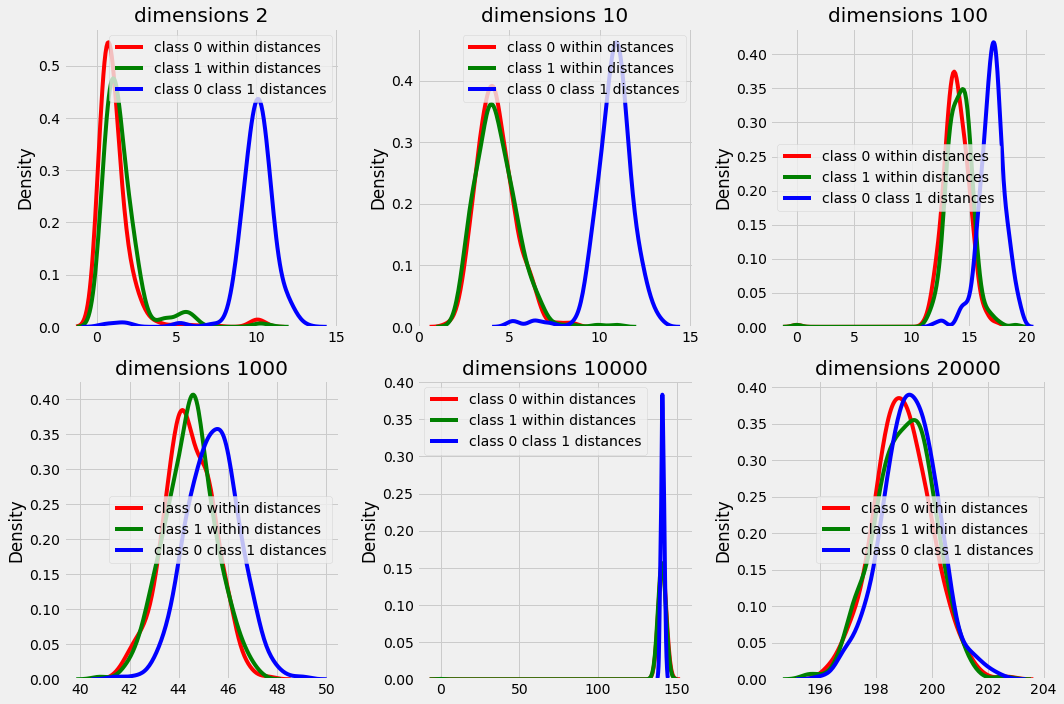

In [75]:

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()

for idx in range(len(n_features)):
    sns.kdeplot(class0_within_distances[idx], color='r', ax=ax[idx], label='class 0 within distances')
    sns.kdeplot(class1_within_distances[idx], color='g', ax=ax[idx], label='class 1 within distances')
    sns.kdeplot(class0_class1_distances[idx], color='b', ax=ax[idx], label='class 0 class 1 distances')
    
    ax[idx].set_title(f"dimensions {n_features[idx]}")
    
    ax[idx].legend()
    
plt.tight_layout()
plt.show()

* In plot above we can observe that the difference between the distances within a class data points and between classes data point are starting to overlap with increasing dimensions. and in higher dimensions the distances are distributed in a very small range (see peak in high dimension plots) that makes it difficult for the algorithm to find out nearest neighbors with majority class k nearest neighbors for every test scenario.

### Regression

* Dimensionality of feature space is higher than number of samples(rows << columns) then also curse of dimensionality concept applies.
* if the number of features are reaching towards number of samples then the model starts to overfit.

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

* generating a dataset with 1000 samples and 500 features.
* with each iteration we are deceasing the number of samples available for fitting the model

In [153]:
total_samples = 1000
n_features = 500
n_samples = [i for i in range(total_samples, 0, -50)]
train_mse = []
test_mse = []
X, y = make_regression(n_samples=total_samples, n_features=n_features, n_targets=1, noise=0, random_state=8888)

# sparse_matrix = generate_sparse_matrix(total_samples, n_features, 0.01)
# X = X * sparse_matrix

for i in n_samples:
    
    X_train, X_test, y_train, y_test = train_test_split(X[:i], y[:i], train_size=0.8)
    
    model = LinearRegression().fit(X_train, y_train)
        
    train_score = mean_squared_error(y_train, model.predict(X_train))
    test_score = mean_squared_error(y_test, model.predict(X_test))

    train_mse.append(train_score)
    test_mse.append(test_score)
    

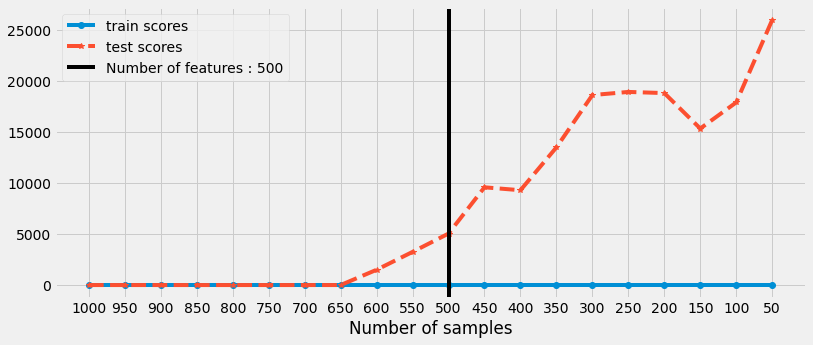

In [154]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(list(map(str, n_samples)), train_mse, 'o-', label='train scores')
ax.plot(list(map(str, n_samples)), test_mse, '*--', label='test scores')
ax.axvline(str(n_features), c='k', label=f'Number of features : {n_features}')

ax.set_xlabel('Number of samples')
plt.legend()
plt.show()

* We can observe that the model is performing well when the number of samples are greater than number of features.
* just as the number of samples are decreasing for training and it is reaching towards number of features then the model starts to overfit (perform well on training and poorly on testing data)